In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
portfolio_kwargs = dict(
    direction='all',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.download('BTC-USD').get('Close')

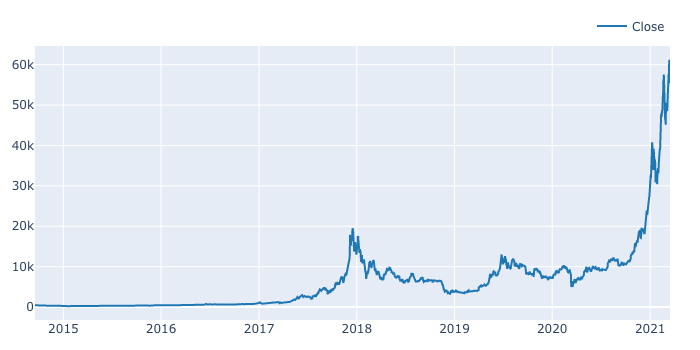

In [4]:
price.vbt.plot().show_png()

In [5]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

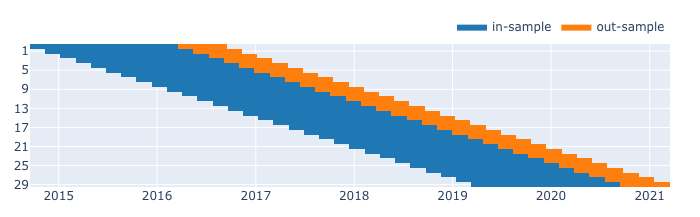

In [6]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_png()

In [7]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [8]:
def simulate_holding(price, **kwargs):
    portfolio = vbt.Portfolio.from_holding(price, **kwargs)
    return portfolio.sharpe_ratio()

In [9]:
in_hold_sharpe = simulate_holding(in_price, **portfolio_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.396165
2     1.181764
3     1.229957
4     1.655467
5     1.904860
6     2.191247
7     2.002450
8     2.298427
9     2.616791
10    2.541334
11    3.037085
12    2.656089
13    2.405612
14    2.197741
15    1.948138
16    1.656441
17    1.480748
18    0.759683
19    0.349988
20    0.330775
21   -0.147073
22    0.576409
23    0.510630
24    0.276865
25    0.456130
26    0.413762
27    0.944417
28    1.217068
29    1.262394
Name: sharpe_ratio, dtype: float64


In [10]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [11]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **portfolio_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.856870
                          1            1.015869
                          2            0.274808
                          3            0.309808
                          4            0.574557
                                         ...   
48           49           25           1.987459
                          26           0.830227
                          27           0.034521
                          28           0.000754
                          29          -0.485749
Name: sharpe_ratio, Length: 23400, dtype: float64


In [12]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [13]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (23, 25,  4),
            (23, 25,  5),
            (41, 42,  6),
            (40, 43,  7),
            (37, 43,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 21, 15),
            (10, 22, 16),
            (10, 22, 17),
            (10, 22, 18),
            (17, 22, 19),
            (17, 22, 20),
            (17, 23, 21),
            (13, 21, 22),
            (45, 49, 23),
            (45, 49, 24),
            (18, 21, 25),
            (18, 21, 26),
            (13, 21, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [14]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [15]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [21 25]
 [23 25]
 [23 25]
 [23 25]
 [41 42]
 [40 43]
 [37 43]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 22]
 [17 22]
 [17 22]
 [17 23]
 [13 21]
 [45 49]
 [45 49]
 [18 21]
 [18 21]
 [13 21]
 [13 20]
 [13 20]]


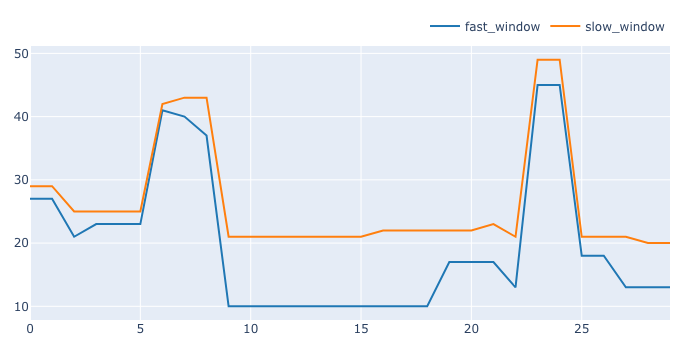

In [16]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_png()

In [17]:
out_hold_sharpe = simulate_holding(out_price, **portfolio_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     1.984613
2     1.752270
3     3.267779
4     2.248745
5     3.173571
6     3.510254
7     3.830162
8     4.264002
9     1.833307
10    1.431637
11   -0.118486
12   -0.229746
13   -0.622004
14   -1.138296
15   -1.334616
16   -1.259312
17    0.011124
18    3.926120
19    2.874779
20    1.319279
21   -0.292846
22    0.291843
23   -0.081432
24    1.052948
25    0.801675
26    1.933410
27    3.193577
28    4.739282
29    4.815842
Name: sharpe_ratio, dtype: float64


In [18]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **portfolio_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -1.278942
                          2            1.540589
                          3            0.718590
                          4            1.573620
                                         ...   
48           49           25          -2.170536
                          26          -1.337703
                          27          -1.036444
                          28           2.894303
                          29           4.201421
Name: sharpe_ratio, Length: 23400, dtype: float64


In [19]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [20]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **portfolio_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            1.164082
                      1            0.445859
21         25         2            1.648568
23         25         3            1.952444
                      4            0.322596
                      5            1.821889
41         42         6            0.394412
40         43         7           -1.772724
37         43         8            1.774542
10         21         9            3.712320
                      10           3.030309
                      11           1.187116
                      12           1.366647
                      13           0.834013
                      14          -0.126803
                      15           0.141026
           22         16           0.938417
                      17           1.332155
                      18           2.651759
17         22         19           1.054028
                      20          -0.412971
           23         21          -0.606754


In [21]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

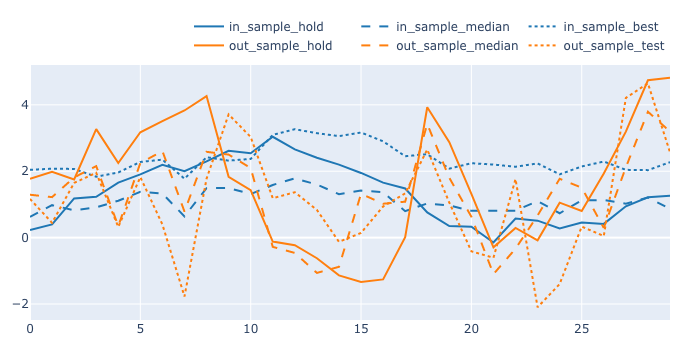

In [22]:
cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=vbt.settings.color_schema['blue']),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dot'),
        dict(line_color=vbt.settings.color_schema['orange']),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dot')
    ]
).show_png()